# The code is to run the RGD tomography method 
1. prepare the quantum state
2. do the measurement
3. do the RGD optimization method to reconstruct the state

In [6]:
import numpy as np

#import qutip as qu
#from states import GHZState, HadamardState, RandomState
from qibo_states import GHZState, HadamardState, RandomState
from qibo import quantum_info

import methodsRGD_core
import methodsMiFGD_core

import measurements
import projectors

from BasicTools import Plt_Err_Time
from BasicTools import Generate_All_labels

In [7]:
#n = 3; labels = Generate_All_labels(n)
#n = 3; labels = projectors.generate_random_label_list(50, n)
n = 4; labels = projectors.generate_random_label_list(120, n)


num_labels  = len(labels)

In [8]:
Nr = 1 

#state   = GHZState(n)
#state   = HadamardState(n)
state   = RandomState(n)

target_density_matrix = state.get_state_matrix()
target_state          = state.get_state_vector()  

[Qibo 0.2.12|INFO|2024-10-11 11:21:38]: Using numpy backend on /CPU:0
[Qibo 0.2.12|INFO|2024-10-11 11:21:38]: Using numpy backend on /CPU:0


### Do the shot measurement

In [9]:
state.create_circuit()
data_dict_list = state.execute_measurement_circuits(labels)
#print(data_dict_list)

data_dict = {}
for ii in range(num_labels):
    label = data_dict_list[ii]['label']
    data_dict[label] = data_dict_list[ii]['count_dict'] 
        
measurement_list = measurements.MeasurementStore.calc_measurement_list(labels, data_dict)

[Qibo 0.2.12|INFO|2024-10-11 11:21:38]: Using numpy backend on /CPU:0


    -------------------         start calc measurment_list        ------------------  

       ****   directly calc & save measurement_list  
       ****   len(label_list) = 120,  len(data_dict) = 120

    -------------         DONE of calculating measurment_list       ------------------  



### construct Pauli matrix Projectors
1. construct the Pauli matrix
2. calculate the exact coefficient

In [10]:
projector_store_path = './testData/qibo'
projector_store = projectors.ProjectorStore(labels)

# 1. construct the sampled Pauli operators
num_cpus, saveP_bulk, Partition_Pj = projector_store.mpPool_map(projector_store_path)
projector_dict = projectors.ProjectorStore.load_PoolMap(projector_store_path, labels)

# 2. calculate the exact coefficients for sampled Pauli operators
projector_list = [projector_dict[label] for label in labels]
yProj_Exact = methodsRGD_core.Amea(projector_list, target_density_matrix, num_labels, 1) # argv[-1] = coef


      Partion_Pj = 0  -->  No partion in Pj

  ***  Pj_file    = ./testData/qibo/Pj_list.pickle  is saved (i.e. dump)
  ***  label_file = ./testData/qibo/labels.pickle   is saved

     pool.map  COMPLETED by #CPU = 16 

     [projectors] num_cpus = 16,  saved bulk Pj = 1 



In [11]:
params_dict = { 'Nr': Nr,
                'target_DM': target_density_matrix,
                'labels': labels,
                'measurement_list': measurement_list,
                'projector_list': projector_list,
                'num_iterations': 150,
                'convergence_check_period': 1 
}

### DO the RGD tomography optimization method

In [12]:
Ch_svd = -1                 #   choice for initial SVD  (0: LA.svd, 1: svds;  2: power_Largest_EigV, -1: rSVD)
InitX_RGD = 1;              #   method of choosing initial X0

worker = methodsRGD_core.BasicWorkerRGD(params_dict)
worker.computeRGD(InitX_RGD, Ch_svd)


  self.coef = 0.3651483716701107
  InitX     = 1
 *********   using randomized-SVD  to construct  X0 = uk @ sDiag @ vkh  **************************
  ***   0-th (A A*) done:   Time --> ATQ: 0.00041604042053222656,  AG: 0.00039386749267578125   ***
  ***   1-th (A A*) done:   Time --> ATQ: 0.00038814544677734375,  AG: 0.00039386749267578125   ***
  ***   2-th (A A*) done:   Time --> ATQ: 0.00038909912109375,  AG: 0.00039076805114746094   ***
  ***   3-th (A A*) done:   Time --> ATQ: 0.0003917217254638672,  AG: 0.00039124488830566406   ***
  ***   4-th (A A*) done:   Time --> ATQ: 0.00038504600524902344,  AG: 0.0004038810729980469   ***
  ***   5-th (A A*) done:   Time --> ATQ: 0.00042319297790527344,  AG: 0.00038886070251464844   ***
  ***   6-th (A A*) done:   Time --> ATQ: 0.0004608631134033203,  AG: 0.0004260540008544922   ***
  ***   7-th (A A*) done:   Time --> ATQ: 0.0003910064697265625,  AG: 0.00041103363037109375   ***
  ***   8-th (A A*) done:   Time --> ATQ: 0.0004200935363769

### Plot the result

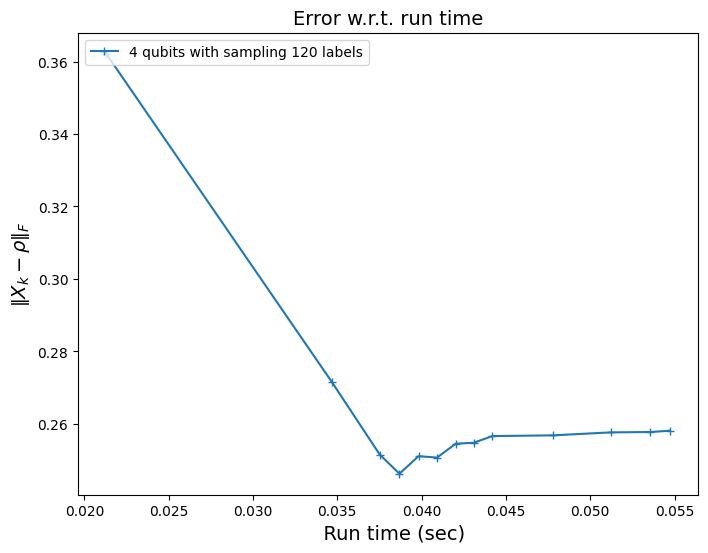

In [13]:
Plt_Err_Time(worker)
